In [87]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.5.1+cpu'

Creating data using Linear Regression \\
We use linear regression to create the data with known parameters (things that can be learned by a model) and then we use PyTorch to see if we can build model to estimate these parameters using gradient descent.


In [88]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Splitting Data \\
We split 80% of our data into the training set and 20% to the testing set

In [89]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

We create a plot to visualize the training and testing data

In [90]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

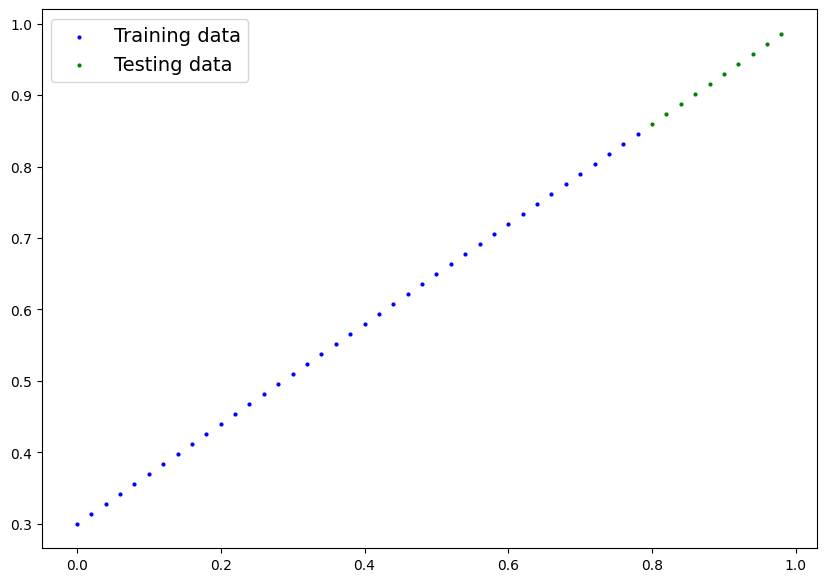

In [91]:
plot_predictions();

Here we build the DNN model class and define how it is to be trained in the \\
(1)Warm up, (2)GP (3)BP phase, how the predictor model is trained and how the alternating between GP and BP phase is performed


In [92]:
# Create a DNN model class
input_size = 28 * 28
hidden_sizes = [128, 64]
output_size = 10
class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DNNModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size)
        )

    def forward(self, x):
        return self.layers(x)
    def train_adagp(model, predictor, dataloader, criterion, optimizer, predictor_optimizer, epochs=10, warmup_epochs=5):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        predictor = predictor.to(device)

        for epoch in range(epochs):
           model.train()
           for i, (inputs, targets) in enumerate(dataloader):
                inputs, targets = inputs.to(device), targets.to(device)
                batch_size = inputs.size(0)

                inputs = inputs.view(batch_size, -1)

                if len(inputs.shape) == 4:  # (batch_size, 1, 28, 28) for MNIST
                  inputs = inputs.view(inputs.size(0), -1)  # Flatten to (batch_size, 784)

            # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                if epoch < warmup_epochs:
                # Warm-up phase: Backpropagate true gradients
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # Train predictor model
                    with torch.no_grad():
                        predicted_gradients = predictor(inputs.view(batch_size, -1))
                    true_gradients = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
                    predictor_loss = nn.MSELoss()(predicted_gradients, torch.cat([g.view(-1) for g in true_gradients]))
                    predictor_optimizer.zero_grad()
                    predictor_loss.backward()
                    predictor_optimizer.step()
                else:
                # Phase BP
                   if i % 2 == 0:  # Alternate between BP and GP
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    # Train predictor model
                        with torch.no_grad():
                            predicted_gradients = predictor(inputs.view(batch_size, -1))
                        true_gradients = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
                        predictor_loss = nn.MSELoss()(predicted_gradients, torch.cat([g.view(-1) for g in true_gradients]))
                        predictor_optimizer.zero_grad()
                        predictor_loss.backward()
                        predictor_optimizer.step()
                   else:
                    # Phase GP: Use predicted gradients
                        predicted_gradients = predictor(inputs.view(batch_size, -1))
                        optimizer.zero_grad()
                        for param, grad in zip(model.parameters(), predicted_gradients.split([p.numel() for p in model.parameters()])):
                            param.grad = grad.view(param.size())
                        optimizer.step()

           print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Here we design the much simpler Gradient Predictor class

In [93]:
class GradientPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(GradientPredictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.layers(x)

Here we create a model instance of the class we made and check its parameters

In [94]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Define input_size, hidden_sizes and output_size
input_size = 1  # Example input size, adjust as needed
hidden_sizes = [128, 64] # Example hidden sizes, adjust as needed
output_size = 1  # Example output size, adjust as needed

# Create an instance of the model providing the necessary arguments
model_0 = DNNModel(input_size, hidden_sizes, output_size)

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([[ 0.7645],
         [ 0.8300],
         [-0.2343],
         [ 0.9186],
         [-0.2191],
         [ 0.2018],
         [-0.4869],
         [ 0.5873],
         [ 0.8815],
         [-0.7336],
         [ 0.8692],
         [ 0.1872],
         [ 0.7388],
         [ 0.1354],
         [ 0.4822],
         [-0.1412],
         [ 0.7709],
         [ 0.1478],
         [-0.4668],
         [ 0.2549],
         [-0.4607],
         [-0.1173],
         [-0.4062],
         [ 0.6634],
         [-0.7894],
         [-0.4610],
         [-0.2824],
         [-0.6013],
         [ 0.0944],
         [-0.9877],
         [ 0.9031],
         [-0.8495],
         [ 0.7720],
         [ 0.1664],
         [-0.3247],
         [ 0.6179],
         [ 0.1559],
         [ 0.8080],
         [ 0.1093],
         [-0.3154],
         [ 0.2687],
         [-0.2712],
         [ 0.4209],
         [ 0.8928],
         [ 0.5781],
         [-0.4372],
         [ 0.5773],
         [ 0.1789],
         [ 0.5078

Making predictions using torch.inference_mode() \\
To check this we pass the test data X_test to see how closely it predicts y_test.

When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we defined.

In [95]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [96]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.0393],
        [0.0412],
        [0.0430],
        [0.0442],
        [0.0451],
        [0.0456],
        [0.0462],
        [0.0467],
        [0.0463],
        [0.0457]])


We visualize our predictions and compare them with training and testing data

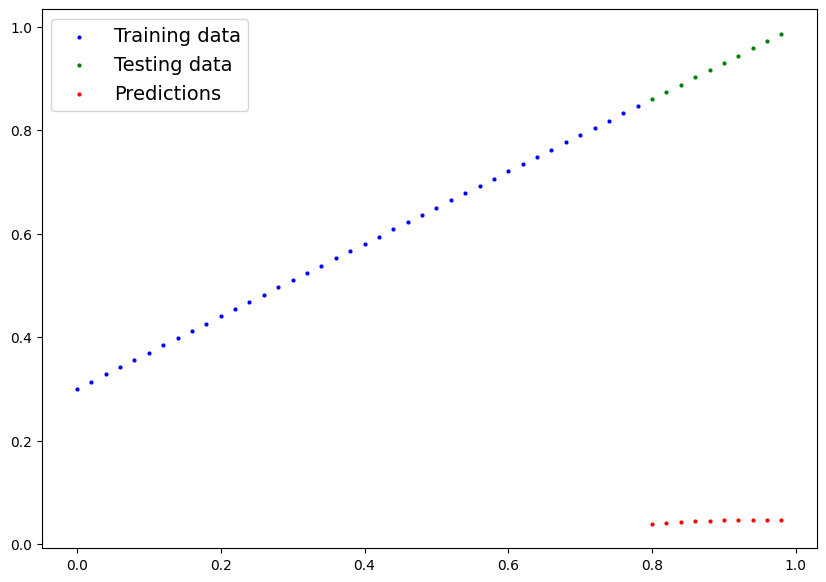

In [97]:
plot_predictions(predictions=y_preds)

In [98]:
y_test - y_preds

tensor([[0.8207],
        [0.8328],
        [0.8450],
        [0.8578],
        [0.8709],
        [0.8844],
        [0.8978],
        [0.9113],
        [0.9257],
        [0.9403]])

To improve our predictions we create a loss function and an optimizer

In [99]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

The code trains and evaluates a model over 100 epochs, tracking training and testing loss to monitor progress. During training, the model is set to training mode, performs a forward pass to generate predictions, computes the loss, calculates gradients through backpropagation, and updates the model parameters. In testing, the model is switched to evaluation mode, and predictions on the test set are used to compute test loss without gradient computation for efficiency. Every 10 epochs, the training and test losses are logged, detached from the computational graph, and printed to track the model's performance and convergence over time.

In [100]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.5559879541397095 | MAE Test Loss: 0.8075816035270691 
Epoch: 10 | MAE Train Loss: 0.09476989507675171 | MAE Test Loss: 0.2538420855998993 
Epoch: 20 | MAE Train Loss: 0.06270377337932587 | MAE Test Loss: 0.17941556870937347 
Epoch: 30 | MAE Train Loss: 0.03794743865728378 | MAE Test Loss: 0.12645277380943298 
Epoch: 40 | MAE Train Loss: 0.01276387833058834 | MAE Test Loss: 0.07291803508996964 
Epoch: 50 | MAE Train Loss: 0.05641229823231697 | MAE Test Loss: 0.10204007476568222 
Epoch: 60 | MAE Train Loss: 0.046429745852947235 | MAE Test Loss: 0.11784379184246063 
Epoch: 70 | MAE Train Loss: 0.04095855727791786 | MAE Test Loss: 0.12139622122049332 
Epoch: 80 | MAE Train Loss: 0.04474173113703728 | MAE Test Loss: 0.12479428946971893 
Epoch: 90 | MAE Train Loss: 0.04599694535136223 | MAE Test Loss: 0.12271241843700409 


Now we plot and visualize the training and testing loss curves

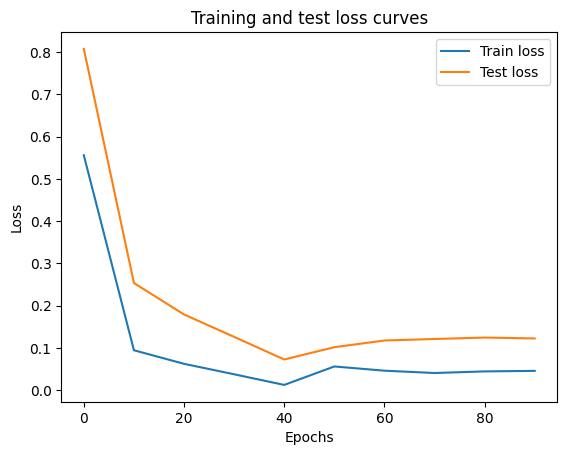

In [101]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Now we print the values for weights and bias after training for 100 epochs

In [102]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('layers.0.weight', tensor([[ 0.7643],
        [ 0.8326],
        [-0.2347],
        [ 0.9215],
        [-0.2191],
        [ 0.2032],
        [-0.4869],
        [ 0.5882],
        [ 0.8815],
        [-0.7336],
        [ 0.8714],
        [ 0.1872],
        [ 0.7426],
        [ 0.1354],
        [ 0.4879],
        [-0.1412],
        [ 0.7693],
        [ 0.1468],
        [-0.4685],
        [ 0.2610],
        [-0.4605],
        [-0.1173],
        [-0.4057],
        [ 0.6638],
        [-0.7894],
        [-0.4610],
        [-0.2807],
        [-0.6013],
        [ 0.0926],
        [-0.9871],
        [ 0.9040],
        [-0.8495],
        [ 0.7744],
        [ 0.1686],
        [-0.3247],
        [ 0.6179],
        [ 0.1576],
        [ 0.8102],
        [ 0.1093],
        [-0.3117],
        [ 0.2688],
        [-0.2712],
        [ 0.4209],
        [ 0.8923],
        [ 0.5789],
        [-0.4372],
        [ 0.5773],
        [ 0.1

In [103]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8543],
        [0.8636],
        [0.8729],
        [0.8814],
        [0.8898],
        [0.8983],
        [0.9065],
        [0.9147],
        [0.9221],
        [0.9292]])

Now the visualize the training, testing and predicted data after training our model. As observed the predictions this time are much better compared to the untrained model with random weights and biases.

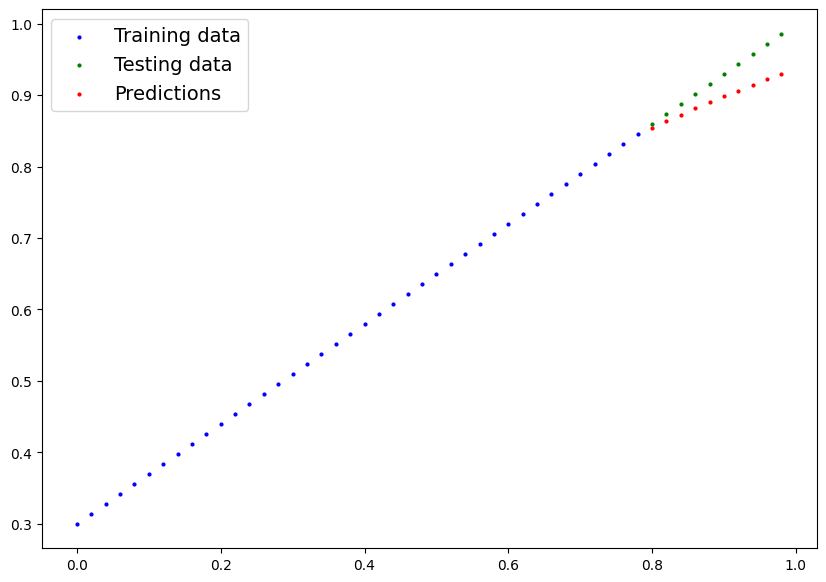

In [104]:
plot_predictions(predictions=y_preds)

Now we save the PyTorch model

In [105]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [106]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 37264 Dec  1 03:35 models/01_pytorch_workflow_model_0.pth


In [107]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = DNNModel(input_size, hidden_sizes, output_size)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-107-de320ceaf16d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [108]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [109]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])